### Introduction to Citation Patterns in Computer Science vs. Other Fields

This analysis delves into the differences in citation patterns between computer science and the broader academic landscape. Leveraging the OpenCitations Meta dataset, it examines the concentration and distribution of citations among authors, with a focus on hyperprolific authorship. By comparing citation trends in computer science with general fields, this study highlights how citation behaviors vary across disciplines.

The investigation uses tools such as the Complementary Cumulative Distribution Function (CCDF) and analyzes metrics like average citations and top 1% author contributions. These methods reveal insights into the "long tail" phenomenon in citation distributions, where a small group of authors accumulates the majority of citations.

Through this comparative approach, the analysis aims to uncover whether computer science exhibits unique characteristics in citation accumulation, shedding light on the dynamics of influence and recognition in academic publishing

In [1]:
from pyspark.sql import SparkSession, udf
from pyspark.sql.functions import sum, col, lit, row_number, count, desc, input_file_name, regexp_extract, lag, mean, percent_rank, when, avg
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob

spark = SparkSession.builder \
    .appName("CCDF Analysis") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memoryOverhead", "1g") \
    .config("spark.executor.cores", "4") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.initialExecutors", "2") \
    .config("spark.dynamicAllocation.minExecutors", "1") \
    .config("spark.dynamicAllocation.maxExecutors", "10") \
    .config("spark.driver.maxResultSize", "3g") \
    .getOrCreate()

24/11/05 10:36:36 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [146]:
# Function to calculate CCDF for a given year and base directory
def compute_ccdf_for_year(base_dir, year):
    folder_path = f"{base_dir}/author-year={year}"
    
    # Read all CSV files in the folder
    df = spark.read.csv(folder_path, header=True, inferSchema=True)
    
    # Filter for valid citation counts (remove zeros or nulls)
    df = df.select("citation_count").filter((col("citation_count").isNotNull()) & (col("citation_count") > 0))
    
    # Define the window specification to rank by citation counts in ascending order
    window_spec = Window.orderBy(col("citation_count").asc())

    # Create a DataFrame with row numbers (ranking of citation counts)
    df_with_rank = df.withColumn("rank", row_number().over(window_spec))

    # Calculate the total number of authors (rows) in the dataset
    total_authors = df.count()

    # Calculate CCDF by dividing the rank by the total number of authors
    df_with_ccdf = df_with_rank.withColumn("ccdf", (total_authors - col("rank")) / total_authors)

    # Collect the data for plotting (stay in Spark until this point for memory optimization)
    ccdf_data = df_with_ccdf.select("citation_count", "ccdf").collect()
    return ccdf_data


In [ ]:
# Base directories for the datasets
base_dir_updated = "/share/smartdata/citations/UPDATED_authors_count"
base_dir_original = "/share/smartdata/citations/authors_count"

# Compute the CCDF for 2010 for both datasets
ccdf_2010_updated_data = compute_ccdf_for_year(base_dir_updated, 2010)
ccdf_2010_original_data = compute_ccdf_for_year(base_dir_original, 2010)

# Extract values for plotting
citation_count_2010_updated = [row.citation_count for row in ccdf_2010_updated_data]
ccdf_values_2010_updated = [row.ccdf for row in ccdf_2010_updated_data]

citation_count_2010_original = [row.citation_count for row in ccdf_2010_original_data]
ccdf_values_2010_original = [row.ccdf for row in ccdf_2010_original_data]


In [149]:
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Function to compute CCDF for a given year and base directory
def compute_ccdf_for_year(base_dir, year):
    folder_path = f"{base_dir}/author-year={year}"
    
    # Read all CSV files in the folder
    df = spark.read.csv(folder_path, header=True, inferSchema=True)
    
    # Filter for valid citation counts (remove zeros or nulls)
    df = df.select("citation_count").filter((F.col("citation_count").isNotNull()) & (F.col("citation_count") > 0))
    
    # Define the window specification to rank by citation counts in ascending order
    window_spec = Window.orderBy(F.col("citation_count").asc())

    # Create a DataFrame with row numbers (ranking of citation counts)
    df_with_rank = df.withColumn("rank", F.row_number().over(window_spec))

    # Calculate the total number of authors (rows) in the dataset
    total_authors = df.count()

    # Calculate CCDF by dividing the rank by the total number of authors
    df_with_ccdf = df_with_rank.withColumn("ccdf", (total_authors - F.col("rank")) / total_authors)

    # Collect the data for printing
    ccdf_data = df_with_ccdf.select("citation_count", "ccdf").collect()
    return ccdf_data

# Base directories for the datasets
base_dir_updated = "/share/smartdata/citations/UPDATED_authors_count"
base_dir_original = "/share/smartdata/citations/authors_count"

# Compute the CCDF for 2010 for both datasets
ccdf_2010_updated_data = compute_ccdf_for_year(base_dir_updated, 2010)
ccdf_2010_original_data = compute_ccdf_for_year(base_dir_original, 2010)

# Convert CCDF data to numpy arrays for easy processing (CS and General datasets)
citation_count_2010_updated = np.array([row.citation_count for row in ccdf_2010_updated_data])
ccdf_values_2010_updated = np.array([row.ccdf for row in ccdf_2010_updated_data])

citation_count_2010_original = np.array([row.citation_count for row in ccdf_2010_original_data])
ccdf_values_2010_original = np.array([row.ccdf for row in ccdf_2010_original_data])

# Define the y-ticks of interest (the CCDF values)
y_ticks = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

# Print the corresponding citation counts for each y-tick (CCDF value) for CS dataset
print("Y-tick (CCDF) values and corresponding X-axis (citation count) values for 2010 CS Dataset:")

for y_tick in y_ticks:
    # Find the closest CCDF value and its corresponding citation count
    closest_index = (np.abs(ccdf_values_2010_updated - y_tick)).argmin()
    closest_citation_count = citation_count_2010_updated[closest_index]
    closest_ccdf_value = ccdf_values_2010_updated[closest_index]
    
    print(f"Y-tick: {y_tick}, Closest CCDF: {closest_ccdf_value}, Citation Count: {closest_citation_count}")

# Print the corresponding citation counts for each y-tick (CCDF value) for General dataset
print("\nY-tick (CCDF) values and corresponding X-axis (citation count) values for 2010 General Dataset:")

for y_tick in y_ticks:
    # Find the closest CCDF value and its corresponding citation count
    closest_index = (np.abs(ccdf_values_2010_original - y_tick)).argmin()
    closest_citation_count = citation_count_2010_original[closest_index]
    closest_ccdf_value = ccdf_values_2010_original[closest_index]
    
    print(f"Y-tick: {y_tick}, Closest CCDF: {closest_ccdf_value}, Citation Count: {closest_citation_count}")


24/10/24 16:30:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:30:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:30:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


24/10/24 16:30:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:30:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


24/10/24 16:30:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:30:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:30:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


24/10/24 16:30:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:30:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Y-tick (CCDF) values and corresponding X-axis (citation count) values for 2010 CS Dataset:
Y-tick: 0.1, Closest CCDF: 0.10000012419392965, Citation Count: 1
Y-tick: 0.01, Closest CCDF: 0.010000095215346064, Citation Count: 4
Y-tick: 0.001, Closest CCDF: 0.0010001751134408052, Citation Count: 12
Y-tick: 0.0001, Closest CCDF: 0.00010018310325027934, Citation Count: 31
Y-tick: 1e-05, Closest CCDF: 9.935514371928528e-06, Citation Count: 53
Y-tick: 1e-06, Closest CCDF: 8.279595309940441e-07, Citation Count: 72
Y-tick: 1e-07, Closest CCDF: 0.0, Citation Count: 81

Y-tick (CCDF) values and corresponding X-axis (citation count) values for 2010 General Dataset:
Y-tick: 0.1, Closest CCDF: 0.09999998775612803, Citation Count: 1
Y-tick: 0.01, Closest CCDF: 0.010000059994972665, Citation Count: 4
Y-tick: 0.001, Closest CCDF: 0.000999957024009376, Citation Count: 14
Y-tick: 0.0001, Closest CCDF: 0.00010003243401685565, Citation Count: 30
Y-tick: 1e-05, Closest CCDF: 1.0039975017603627e-05, Citation 

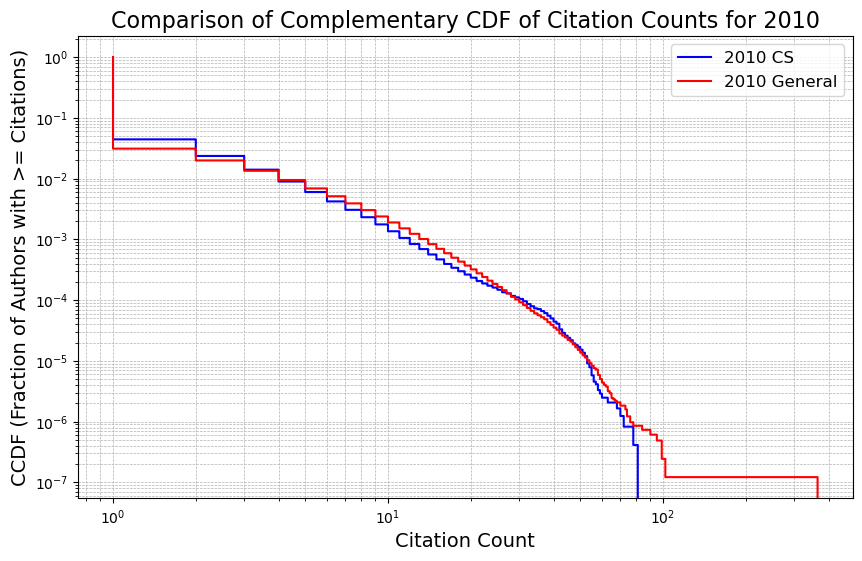

In [12]:
# Plotting the corrected CCDF for 2010 from both datasets (log scale on Y-axis)
plt.figure(figsize=(10, 6))
plt.step(citation_count_2010_updated, ccdf_values_2010_updated, label="2010 CS", where='post', color='blue')
plt.step(citation_count_2010_original, ccdf_values_2010_original, label="2010 General", where='post', color='red')
plt.title("Comparison of Complementary CDF of Citation Counts for 2010", fontsize=16)
plt.xlabel("Citation Count", fontsize=14)
plt.ylabel("CCDF (Fraction of Authors with >= Citations)", fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend(fontsize=12)
plt.savefig('filtered/CCDF_Comparison_2010.png')
plt.show()

In [150]:
# Function to calculate CCDF for a given year and base directory using Spark
def compute_ccdf_for_year(base_dir, year):
    folder_path = f"{base_dir}/author-year={year}"
    df = spark.read.csv(folder_path, header=True, inferSchema=True)
    df = df.select("citation_count").filter((col("citation_count").isNotNull()) & (col("citation_count") > 0))
    window_spec = Window.orderBy(col("citation_count").asc())
    df_with_rank = df.withColumn("rank", row_number().over(window_spec))
    total_authors = df.count()
    df_with_ccdf = df_with_rank.withColumn("ccdf", (total_authors - col("rank")) / total_authors)
    return df_with_ccdf

# Compute the CCDF for updated 2020 data
base_dir_updated = "/share/smartdata/citations/UPDATED_authors_count"
ccdf_2020_updated_df = compute_ccdf_for_year(base_dir_updated, 2020)

# Convert Spark DataFrame to Pandas for plotting
ccdf_2020_updated_pd = ccdf_2020_updated_df.toPandas()

# Paths where the original 2020 CSV data is stored
output_path_2020_original = "/share/smartdata/citations/year=2020"
# Load data from CSV files using Pandas
ccdf_2020_df_original = pd.concat((pd.read_csv(f) for f in glob.glob(output_path_2020_original + "/*.csv")), ignore_index=True)

# Extract values for plotting
citation_count_2020_original = ccdf_2020_df_original['citation_count'].tolist()
ccdf_values_2020_original = ccdf_2020_df_original['ccdf'].tolist()

citation_count_2020_updated = ccdf_2020_updated_pd['citation_count'].tolist()
ccdf_values_2020_updated = ccdf_2020_updated_pd['ccdf'].tolist()

24/10/24 16:42:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:42:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:42:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


24/10/24 16:42:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:42:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [154]:
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Function to calculate CCDF for a given year and base directory using Spark
def compute_ccdf_for_year(base_dir, year):
    folder_path = f"{base_dir}/author-year={year}"
    
    # Read all CSV files in the folder
    df = spark.read.csv(folder_path, header=True, inferSchema=True)
    
    # Filter for valid citation counts (remove zeros or nulls)
    df = df.select("citation_count").filter((F.col("citation_count").isNotNull()) & (F.col("citation_count") > 0))
    
    # Define the window specification to rank by citation counts in ascending order
    window_spec = Window.orderBy(F.col("citation_count").asc())

    # Create a DataFrame with row numbers (ranking of citation counts)
    df_with_rank = df.withColumn("rank", F.row_number().over(window_spec))

    # Calculate the total number of authors (rows) in the dataset
    total_authors = df.count()

    # Calculate CCDF by dividing the rank by the total number of authors
    df_with_ccdf = df_with_rank.withColumn("ccdf", (total_authors - F.col("rank")) / total_authors)

    return df_with_ccdf

# Base directories for the datasets
base_dir_updated = "/share/smartdata/citations/UPDATED_authors_count"
base_dir_original = "/share/smartdata/citations/authors_count"

# Compute the CCDF for updated 2020 data
ccdf_2020_updated_df = compute_ccdf_for_year(base_dir_updated, 2020)
ccdf_2020_original_df = compute_ccdf_for_year(base_dir_original, 2020)

# Define the y-ticks of interest (the CCDF values)
y_ticks = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

# For each y-tick, find the closest citation count in Spark for the updated 2020 dataset
print("Y-tick (CCDF) values and corresponding X-axis (citation count) values for 2020 CS Dataset (Updated):")
for y_tick in y_ticks:
    closest_row = ccdf_2020_updated_df.orderBy(F.abs(F.col("ccdf") - y_tick)).limit(1).collect()[0]
    citation_count = closest_row['citation_count']
    ccdf_value = closest_row['ccdf']
    print(f"Y-tick: {y_tick}, Closest CCDF: {ccdf_value}, Citation Count: {citation_count}")

# For each y-tick, find the closest citation count in Spark for the original 2020 dataset
print("\nY-tick (CCDF) values and corresponding X-axis (citation count) values for 2020 General Dataset (Original):")
for y_tick in y_ticks:
    closest_row = ccdf_2020_original_df.orderBy(F.abs(F.col("ccdf") - y_tick)).limit(1).collect()[0]
    citation_count = closest_row['citation_count']
    ccdf_value = closest_row['ccdf']
    print(f"Y-tick: {y_tick}, Closest CCDF: {ccdf_value}, Citation Count: {citation_count}")


Y-tick (CCDF) values and corresponding X-axis (citation count) values for 2020 CS Dataset (Updated):
24/10/24 16:50:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


24/10/24 16:50:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Y-tick: 0.1, Closest CCDF: 0.10000005749905558, Citation Count: 1
24/10/24 16:50:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


24/10/24 16:50:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Y-tick: 0.01, Closest CCDF: 0.010000044082609277, Citation Count: 4
24/10/24 16:50:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


24/10/24 16:50:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Y-tick: 0.001, Closest CCDF: 0.000999908576501631, Citation Count: 13
24/10/24 16:50:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


24/10/24 16:50:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Y-tick: 0.0001, Closest CCDF: 0.0001000483567057411, Citation Count: 42
24/10/24 16:50:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


24/10/24 16:50:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Y-tick: 1e-05, Closest CCDF: 9.966502966855437e-06, Citation Count: 87
24/10/24 16:50:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


24/10/24 16:50:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Y-tick: 1e-06, Closest CCDF: 9.58317592966869e-07, Citation Count: 98
24/10/24 16:50:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


24/10/24 16:50:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Y-tick: 1e-07, Closest CCDF: 1.9166351859337378e-07, Citation Count: 170

Y-tick (CCDF) values and corresponding X-axis (citation count) values for 2020 General Dataset (Original):
24/10/24 16:50:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


24/10/24 16:50:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Y-tick: 0.1, Closest CCDF: 0.09999998073251509, Citation Count: 1
24/10/24 16:50:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:50:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


24/10/24 16:51:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:51:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Y-tick: 0.01, Closest CCDF: 0.010000017340736415, Citation Count: 5
24/10/24 16:51:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:51:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:51:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


24/10/24 16:51:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:51:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Y-tick: 0.001, Closest CCDF: 0.0009999824665887361, Citation Count: 15
24/10/24 16:51:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:51:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:51:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


24/10/24 16:51:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:51:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Y-tick: 0.0001, Closest CCDF: 9.999824665887361e-05, Citation Count: 36
24/10/24 16:51:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:51:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:51:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


24/10/24 16:51:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:51:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Y-tick: 1e-05, Closest CCDF: 1.0019092150792732e-05, Citation Count: 76
24/10/24 16:51:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:51:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:51:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


24/10/24 16:51:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:51:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Y-tick: 1e-06, Closest CCDF: 1.0275991949531007e-06, Citation Count: 121
24/10/24 16:51:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:51:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:51:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


24/10/24 16:51:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/24 16:51:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Y-tick: 1e-07, Closest CCDF: 1.2844989936913759e-07, Citation Count: 198


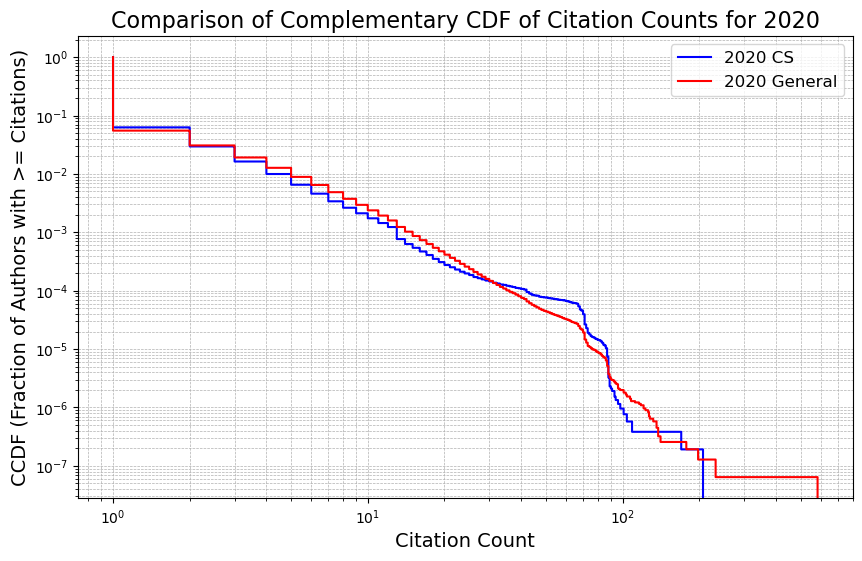

In [120]:
# Plotting the corrected CCDF for 2020 from both datasets
plt.figure(figsize=(10, 6))
plt.step(citation_count_2020_updated, ccdf_values_2020_updated, label="2020 CS", where='post', color='blue')
plt.step(citation_count_2020_original, ccdf_values_2020_original, label="2020 General", where='post', color='red')
plt.title("Comparison of Complementary CDF of Citation Counts for 2020", fontsize=16)
plt.xlabel("Citation Count", fontsize=14)
plt.ylabel("CCDF (Fraction of Authors with >= Citations)", fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend(fontsize=12)
plt.savefig('filtered/CCDF_Comparison_2020.png')

plt.show()

In [14]:
import json

# Load the JSON file
with open('/share/smartdata/citations/alice_map.json', 'r') as file:
    data = json.load(file)

# Display the first 10 rows
data[:10]


[{'id': '53e99784b7602d9701f3ffdd',
  'v12_id': None,
  'title': 'Flow.',
  'venue_raw': 'SIGGRAPH Art Gallery',
  'year': 2006,
  'keywords': [],
  'references': [],
  'n_citation': 15,
  'page_start': '',
  'page_end': '',
  'doc_type': 'Conference',
  'lang': 'en',
  'volume': '',
  'issue': '10',
  'issn': '',
  'isbn': '',
  'doi': '10.1145/1280120.1280225',
  'url': [],
  'abstract': '',
  'authors_ids': ['53f43776dabfaee0d9b6e75b'],
  'v12_authors_id': [],
  'authors_names': ['Masa Inakage'],
  'v12_authors_names': [],
  'authors_org': []},
 {'id': '53e99785b7602d9701f41492',
  'v12_id': None,
  'title': 'Dancing',
  'venue_raw': 'ACM SIGGRAPH 98 Electronic art and animation catalog',
  'year': 1998,
  'keywords': [],
  'references': [],
  'n_citation': 0,
  'page_start': '116',
  'page_end': '116',
  'doc_type': 'Conference',
  'lang': 'en',
  'volume': '3',
  'issue': '19',
  'issn': '0036-8733',
  'isbn': '1-58113-045-7',
  'doi': '10.1145/281388.281845',
  'url': ['http://dx

### Average all and top 1 citation per author

In [122]:
# Define the range of years for the analysis
years = list(range(2010, 2021))

# Read and aggregate data from each year
def read_data(year):
    path = f"/share/smartdata/citations/UPDATED_authors_count/author-year={year}/*.csv"
    return spark.read.csv(path, schema="author STRING, citation_count INT").withColumn("year", lit(year))

# Union all dataframes
from functools import reduce
from pyspark.sql import DataFrame
data = reduce(DataFrame.unionAll, [read_data(year) for year in years])

# Assuming 'data' is your DataFrame that includes all authors and their citation counts per year
yearly_avg_citations = data.groupBy("year").agg(avg("citation_count").alias("avg_citations"))
yearly_avg_citations = yearly_avg_citations.orderBy("year")  # Ordering by year for chronological data
yearly_avg_citations.show()

#total_citations.show()

+----+------------------+
|year|     avg_citations|
+----+------------------+
|2010|1.1173731990327778|
|2011|1.1163784595723896|
|2012|1.1168040890945043|
|2013|1.1253875653374827|
|2014|1.1287918884149306|
|2015|1.1309897376160292|
|2016|1.1299541343464827|
|2017|1.1352331406145237|
|2018| 1.141886253741058|
|2019|1.1449615422041917|
|2020|1.1514300877608086|
+----+------------------+



In [140]:
# Aggregate total citations per author across the entire period
total_citations_per_author = data.groupBy("author").agg(sum("citation_count").alias("total_citations"))

# Calculate the 99th percentile threshold for being in the top 1%
top_1_percent_threshold = total_citations_per_author.approxQuantile("total_citations", [0.99], 0.01)[0]

# Filter to get the top 1% authors
top_1_percent_authors = total_citations_per_author.filter(total_citations_per_author["total_citations"] >= top_1_percent_threshold)
#top_1_percent_authors.show()


In [124]:
# Join the data with the top 1% authors to filter only their citation records
top_1_percent_data = data.join(top_1_percent_authors, "author")

# Calculate the yearly average citations for the top 1%
yearly_avg_citations_top_1_percent = top_1_percent_data.groupBy("year").agg(avg("citation_count").alias("avg_citations_top_1"))
yearly_avg_citations_top_1_percent = yearly_avg_citations_top_1_percent.orderBy("year")
yearly_avg_citations_top_1_percent.show()


+----+-------------------+
|year|avg_citations_top_1|
+----+-------------------+
|2010|               48.0|
|2011|              117.0|
|2012|              147.0|
|2013|              121.0|
|2014|               95.0|
|2015|               87.0|
|2016|              117.0|
|2017|              121.0|
|2018|              117.0|
|2019|              109.0|
|2020|               82.0|
+----+-------------------+



In [125]:
# Collect data for plotting (assuming it's manageable size)
avg_citations_all = yearly_avg_citations.collect()
avg_citations_top_1 = yearly_avg_citations_top_1_percent.collect()

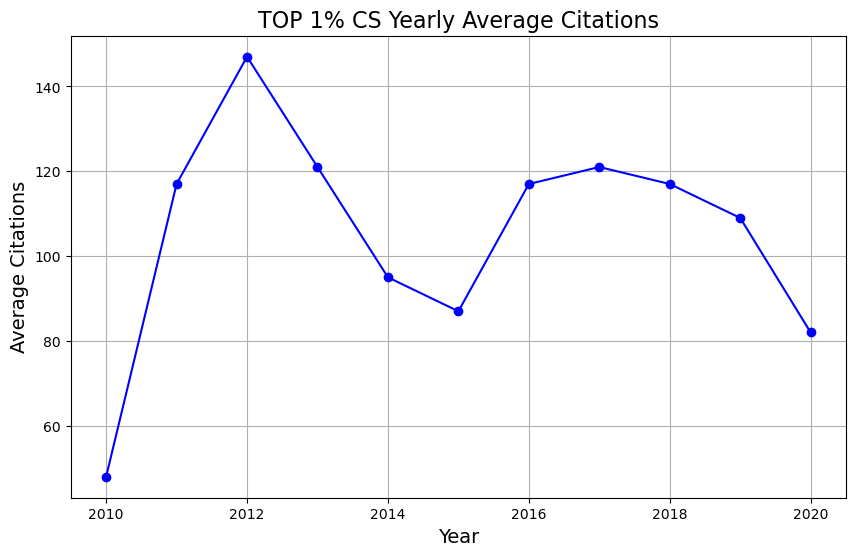

In [126]:
import matplotlib.pyplot as plt

# Plotting the average citations over time for all authors and top 1%
plt.figure(figsize=(10, 6))
years = [row['year'] for row in avg_citations_all]
avg_citations_1_percent = [row['avg_citations_top_1'] for row in avg_citations_top_1]

plt.plot(years, avg_citations_1_percent, label='CS',marker='o', linestyle='-', color = 'blue')
#plt.plot(years, unfiltered_avg_citations_1_percent, label='Generak',marker='o', linestyle='-', color = 'orange')

plt.xlabel('Year', fontsize =14)
plt.ylabel('Average Citations', fontsize =14)
plt.title('TOP 1% CS Yearly Average Citations', fontsize =16)
#plt.legend()
plt.grid(True)
plt.savefig('filtered/AvgCitTop1.png')

plt.show()

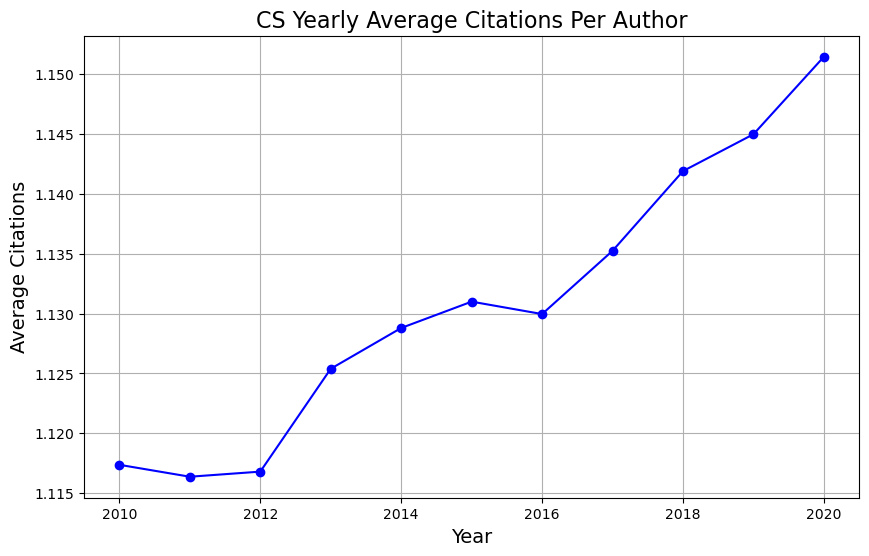

In [59]:
# Collect the data for plotting
avg_citations_data = yearly_avg_citations.collect()
import matplotlib.pyplot as plt

# Extract years and average citations from the collected data
years = [row['year'] for row in avg_citations_data]
avg_citations = [row['avg_citations'] for row in avg_citations_data]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(years, avg_citations, marker='o', linestyle='-', color='blue')
plt.title('CS Yearly Average Citations Per Author', fontsize = 16)
plt.xlabel('Year', fontsize =14)
plt.ylabel('Average Citations', fontsize =14)
plt.grid(True)
plt.savefig('filtered/avgCit.png')
plt.show()

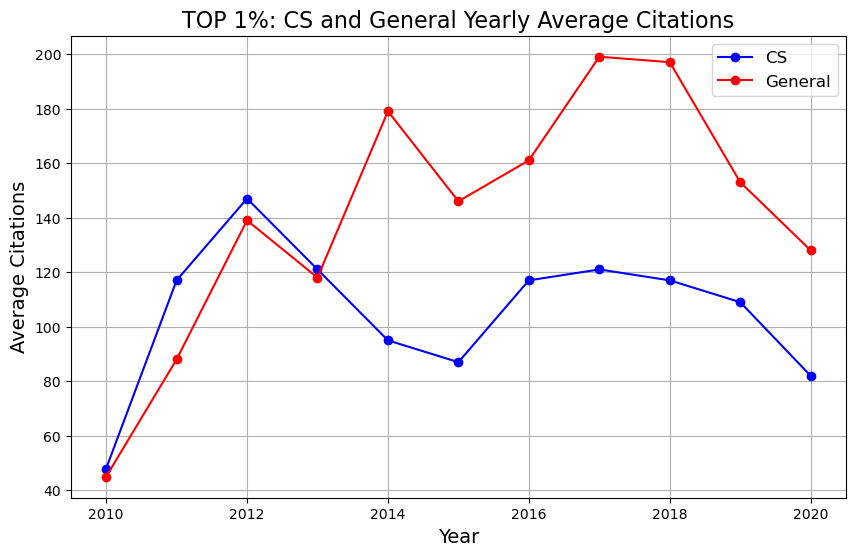

In [128]:
import matplotlib.pyplot as plt

# Plotting the average citations over time for all authors and top 1%
plt.figure(figsize=(10, 6))
years = [row['year'] for row in avg_citations_all]
avg_citations_1_percent = [row['avg_citations_top_1'] for row in avg_citations_top_1]

plt.plot(years, avg_citations_1_percent, label='CS',marker='o', linestyle='-', color = 'blue')
plt.plot(years, unfiltered_avg_citations_1_percent, label='General',marker='o', linestyle='-', color = 'red')

plt.xlabel('Year', fontsize =14)
plt.ylabel('Average Citations', fontsize =14)
plt.title('TOP 1%: CS and General Yearly Average Citations', fontsize =16)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('filtered/comparisonAvgCitTop1.png')

plt.show()

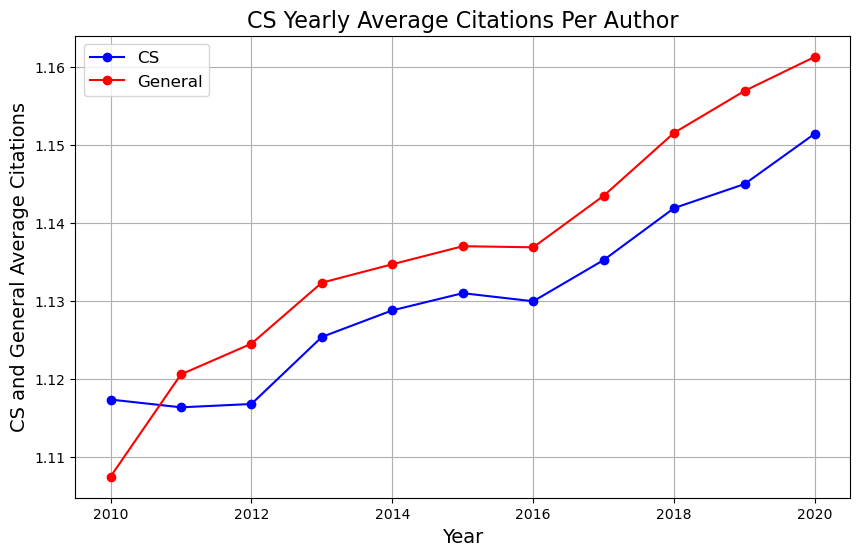

In [116]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(years, avg_citations, label = 'CS', marker='o', linestyle='-', color='blue')
plt.plot(years, unfiltered_avg_citations, label = 'General', marker='o', linestyle='-', color='red')

plt.title('CS Yearly Average Citations Per Author', fontsize = 16)
plt.xlabel('Year', fontsize =14)
plt.ylabel('CS and General Average Citations', fontsize =14)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('filtered/comparisonAvgCit.png')
plt.show()

In [5]:
spark.stop()

24/11/01 16:12:46 WARN ExecutorPodsWatchSnapshotSource: Kubernetes client has been closed.
